# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

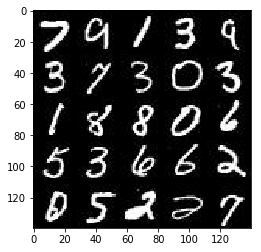

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

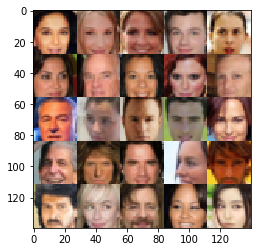

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None,image_width,image_width,
                                            image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return (inputs_real,inputs_z,learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',activation=None)
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',activation=None)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2,keep_prob=0.9)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',activation=None)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3,keep_prob=0.9)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits) 
        
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim,is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.05),
                                        activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2,keep_prob=0.9)

        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.05),
                                        activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3,keep_prob=0.9)
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(stddev=0.05),
                                            activation=None)
        #logits = tf.reshape(logits, (None,28,28,out_channel_dim))
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha =0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) *(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every=10
    show_every=100
    steps = 0
    
    samples,width,height,channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width,height,channels,z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, channels, alpha=0.2)   
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training

                if steps % show_every == 0:
                    show_generator_output(sess, 24, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5305... Generator Loss: 2.3187
Epoch 1/2... Discriminator Loss: 0.4568... Generator Loss: 2.6239
Epoch 1/2... Discriminator Loss: 0.3874... Generator Loss: 3.5882
Epoch 1/2... Discriminator Loss: 0.8533... Generator Loss: 2.6582
Epoch 1/2... Discriminator Loss: 1.5092... Generator Loss: 0.5401
Epoch 1/2... Discriminator Loss: 1.3978... Generator Loss: 0.5695
Epoch 1/2... Discriminator Loss: 0.7786... Generator Loss: 1.8187
Epoch 1/2... Discriminator Loss: 0.7602... Generator Loss: 1.9863
Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 2.6900
Epoch 1/2... Discriminator Loss: 1.4837... Generator Loss: 3.3356


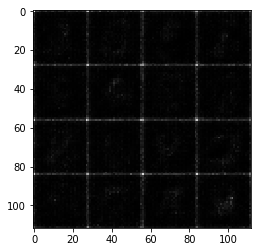

Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 1.2865
Epoch 1/2... Discriminator Loss: 1.4702... Generator Loss: 0.5535
Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 1.2681
Epoch 1/2... Discriminator Loss: 0.9944... Generator Loss: 2.1446
Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 2.1380
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 1.8578
Epoch 1/2... Discriminator Loss: 1.2289... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 1.3802... Generator Loss: 0.6175
Epoch 1/2... Discriminator Loss: 0.8910... Generator Loss: 1.6923


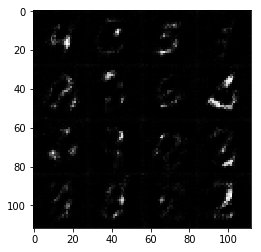

Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 0.6469
Epoch 1/2... Discriminator Loss: 0.8885... Generator Loss: 1.7536
Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 1.0917
Epoch 1/2... Discriminator Loss: 0.8142... Generator Loss: 1.7054
Epoch 1/2... Discriminator Loss: 1.0087... Generator Loss: 0.9799
Epoch 1/2... Discriminator Loss: 0.8799... Generator Loss: 1.5248
Epoch 1/2... Discriminator Loss: 1.1830... Generator Loss: 2.8026
Epoch 1/2... Discriminator Loss: 0.9569... Generator Loss: 2.1762
Epoch 1/2... Discriminator Loss: 0.7980... Generator Loss: 1.8793
Epoch 1/2... Discriminator Loss: 0.7631... Generator Loss: 1.4877


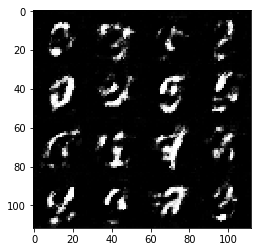

Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 1.6723
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 2.1084
Epoch 1/2... Discriminator Loss: 0.7923... Generator Loss: 1.4434
Epoch 1/2... Discriminator Loss: 0.8353... Generator Loss: 1.4691
Epoch 1/2... Discriminator Loss: 0.7602... Generator Loss: 1.5743
Epoch 1/2... Discriminator Loss: 0.9169... Generator Loss: 1.0966
Epoch 1/2... Discriminator Loss: 0.8406... Generator Loss: 2.5121
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 1.7622
Epoch 1/2... Discriminator Loss: 0.6531... Generator Loss: 2.0228
Epoch 1/2... Discriminator Loss: 1.6605... Generator Loss: 0.3725


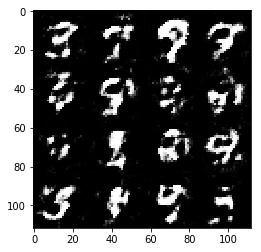

Epoch 1/2... Discriminator Loss: 0.6387... Generator Loss: 1.8987
Epoch 1/2... Discriminator Loss: 0.7058... Generator Loss: 1.6695
Epoch 1/2... Discriminator Loss: 0.8891... Generator Loss: 1.1051
Epoch 1/2... Discriminator Loss: 0.8137... Generator Loss: 1.2452
Epoch 1/2... Discriminator Loss: 0.6865... Generator Loss: 1.4987
Epoch 1/2... Discriminator Loss: 0.9445... Generator Loss: 0.9600
Epoch 1/2... Discriminator Loss: 0.7247... Generator Loss: 2.7255
Epoch 1/2... Discriminator Loss: 0.6317... Generator Loss: 1.6941
Epoch 1/2... Discriminator Loss: 0.6433... Generator Loss: 2.5923
Epoch 1/2... Discriminator Loss: 0.5914... Generator Loss: 2.4065


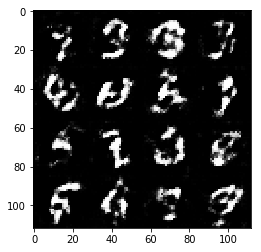

Epoch 1/2... Discriminator Loss: 0.6079... Generator Loss: 2.4555
Epoch 1/2... Discriminator Loss: 0.6258... Generator Loss: 3.0495
Epoch 1/2... Discriminator Loss: 0.6279... Generator Loss: 1.7394
Epoch 1/2... Discriminator Loss: 0.6966... Generator Loss: 1.7214
Epoch 1/2... Discriminator Loss: 0.8852... Generator Loss: 1.1240
Epoch 1/2... Discriminator Loss: 0.6913... Generator Loss: 1.5097
Epoch 1/2... Discriminator Loss: 0.6740... Generator Loss: 2.1087
Epoch 1/2... Discriminator Loss: 0.5011... Generator Loss: 2.1516
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 0.9216
Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 2.6242


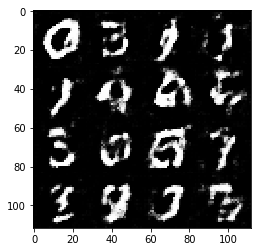

Epoch 1/2... Discriminator Loss: 0.5620... Generator Loss: 2.5246
Epoch 1/2... Discriminator Loss: 0.6477... Generator Loss: 1.9378
Epoch 1/2... Discriminator Loss: 0.5404... Generator Loss: 2.2302
Epoch 1/2... Discriminator Loss: 0.5164... Generator Loss: 2.3370
Epoch 1/2... Discriminator Loss: 0.7143... Generator Loss: 1.5608
Epoch 1/2... Discriminator Loss: 0.6647... Generator Loss: 2.4300
Epoch 1/2... Discriminator Loss: 0.5971... Generator Loss: 1.8681
Epoch 1/2... Discriminator Loss: 0.5327... Generator Loss: 2.5198
Epoch 1/2... Discriminator Loss: 0.5477... Generator Loss: 2.1281
Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 4.1656


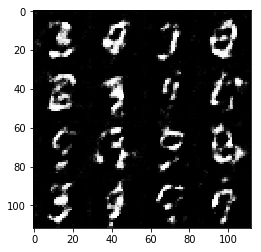

Epoch 1/2... Discriminator Loss: 0.8281... Generator Loss: 1.0909
Epoch 1/2... Discriminator Loss: 0.5515... Generator Loss: 2.7106
Epoch 1/2... Discriminator Loss: 0.6243... Generator Loss: 1.8760
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 0.8212
Epoch 1/2... Discriminator Loss: 0.6179... Generator Loss: 1.9744
Epoch 1/2... Discriminator Loss: 1.5243... Generator Loss: 4.8132
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 1.5315
Epoch 1/2... Discriminator Loss: 0.6184... Generator Loss: 2.2709
Epoch 1/2... Discriminator Loss: 0.5678... Generator Loss: 2.2758
Epoch 1/2... Discriminator Loss: 0.7179... Generator Loss: 2.4664


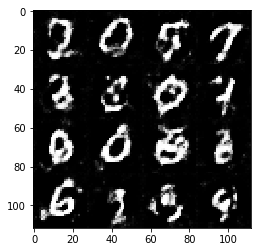

Epoch 1/2... Discriminator Loss: 0.6189... Generator Loss: 2.3269
Epoch 1/2... Discriminator Loss: 0.5967... Generator Loss: 2.4643
Epoch 1/2... Discriminator Loss: 0.6315... Generator Loss: 1.8818
Epoch 1/2... Discriminator Loss: 0.6709... Generator Loss: 1.6205
Epoch 1/2... Discriminator Loss: 0.6911... Generator Loss: 1.4838
Epoch 1/2... Discriminator Loss: 0.8215... Generator Loss: 2.5417
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.8298
Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 3.6724
Epoch 1/2... Discriminator Loss: 0.7135... Generator Loss: 1.6304
Epoch 1/2... Discriminator Loss: 0.7267... Generator Loss: 1.5386


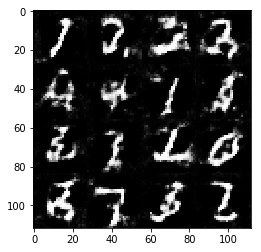

Epoch 1/2... Discriminator Loss: 0.7922... Generator Loss: 2.0592
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 3.0764
Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 1.0727
Epoch 2/2... Discriminator Loss: 0.7891... Generator Loss: 1.4050
Epoch 2/2... Discriminator Loss: 0.7103... Generator Loss: 1.8130
Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.3247
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 1.2632
Epoch 2/2... Discriminator Loss: 1.1488... Generator Loss: 3.3740
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 1.4385
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 2.4479


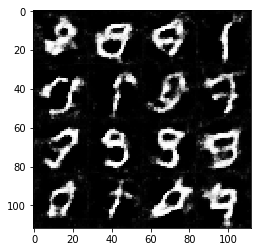

Epoch 2/2... Discriminator Loss: 0.7496... Generator Loss: 1.6063
Epoch 2/2... Discriminator Loss: 0.8028... Generator Loss: 1.4151
Epoch 2/2... Discriminator Loss: 1.1618... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 1.3724
Epoch 2/2... Discriminator Loss: 1.1644... Generator Loss: 0.8274
Epoch 2/2... Discriminator Loss: 0.8836... Generator Loss: 1.0738
Epoch 2/2... Discriminator Loss: 0.7468... Generator Loss: 1.4385
Epoch 2/2... Discriminator Loss: 0.7680... Generator Loss: 1.5415
Epoch 2/2... Discriminator Loss: 0.7936... Generator Loss: 1.7290
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 0.8946


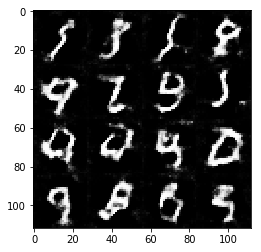

Epoch 2/2... Discriminator Loss: 0.8173... Generator Loss: 1.8086
Epoch 2/2... Discriminator Loss: 0.7342... Generator Loss: 1.9239
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 2.4204
Epoch 2/2... Discriminator Loss: 0.7945... Generator Loss: 1.3349
Epoch 2/2... Discriminator Loss: 0.7601... Generator Loss: 1.4803
Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 2.5963
Epoch 2/2... Discriminator Loss: 0.9003... Generator Loss: 1.4785
Epoch 2/2... Discriminator Loss: 0.8778... Generator Loss: 1.4330
Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 1.1212
Epoch 2/2... Discriminator Loss: 0.7584... Generator Loss: 1.6694


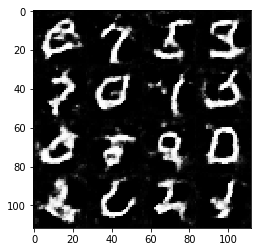

Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 1.1360
Epoch 2/2... Discriminator Loss: 0.7527... Generator Loss: 1.5170
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 1.4029
Epoch 2/2... Discriminator Loss: 0.8349... Generator Loss: 1.4842
Epoch 2/2... Discriminator Loss: 0.7498... Generator Loss: 1.8014
Epoch 2/2... Discriminator Loss: 0.7736... Generator Loss: 1.9789
Epoch 2/2... Discriminator Loss: 0.7807... Generator Loss: 2.0887
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.3494
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 0.6993
Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 0.9289


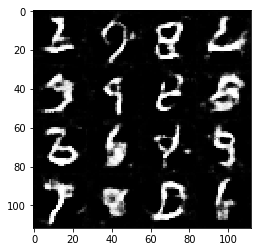

Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 0.5909
Epoch 2/2... Discriminator Loss: 0.7965... Generator Loss: 1.2178
Epoch 2/2... Discriminator Loss: 1.0764... Generator Loss: 0.9594
Epoch 2/2... Discriminator Loss: 0.7374... Generator Loss: 1.5485
Epoch 2/2... Discriminator Loss: 0.9130... Generator Loss: 1.9713
Epoch 2/2... Discriminator Loss: 1.1168... Generator Loss: 0.9011
Epoch 2/2... Discriminator Loss: 0.8043... Generator Loss: 1.3081
Epoch 2/2... Discriminator Loss: 0.8474... Generator Loss: 1.3666
Epoch 2/2... Discriminator Loss: 0.7611... Generator Loss: 2.0846
Epoch 2/2... Discriminator Loss: 0.7603... Generator Loss: 1.8530


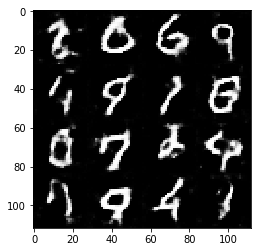

Epoch 2/2... Discriminator Loss: 0.6839... Generator Loss: 1.6228
Epoch 2/2... Discriminator Loss: 0.7966... Generator Loss: 1.7918
Epoch 2/2... Discriminator Loss: 0.7606... Generator Loss: 2.1094
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 0.9563
Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.1632
Epoch 2/2... Discriminator Loss: 0.7573... Generator Loss: 1.7220
Epoch 2/2... Discriminator Loss: 0.8146... Generator Loss: 1.4076
Epoch 2/2... Discriminator Loss: 0.8137... Generator Loss: 1.8423
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 2.1811
Epoch 2/2... Discriminator Loss: 0.7602... Generator Loss: 1.9572


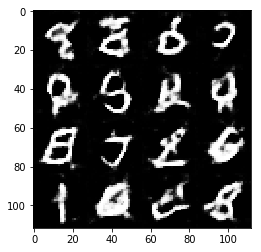

Epoch 2/2... Discriminator Loss: 0.9829... Generator Loss: 1.4659
Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 1.6492
Epoch 2/2... Discriminator Loss: 0.7975... Generator Loss: 1.7064
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 0.8267
Epoch 2/2... Discriminator Loss: 0.8810... Generator Loss: 1.1362
Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.7598
Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 0.8430
Epoch 2/2... Discriminator Loss: 0.8173... Generator Loss: 1.7267
Epoch 2/2... Discriminator Loss: 0.9687... Generator Loss: 2.6107
Epoch 2/2... Discriminator Loss: 0.7868... Generator Loss: 1.7035


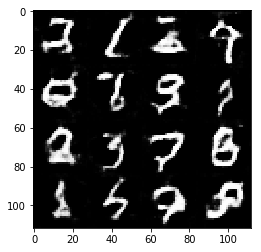

Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.7785
Epoch 2/2... Discriminator Loss: 1.0609... Generator Loss: 1.0293
Epoch 2/2... Discriminator Loss: 0.9296... Generator Loss: 1.1743
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 2.5997
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 1.6951
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 2.1955
Epoch 2/2... Discriminator Loss: 0.8473... Generator Loss: 1.1196
Epoch 2/2... Discriminator Loss: 0.9326... Generator Loss: 0.9212
Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 1.2187
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 1.6669


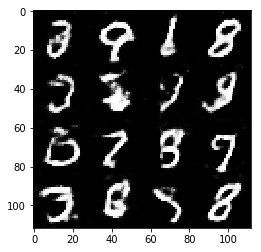

Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 1.3533
Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 1.4222
Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 1.7580
Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 1.8693
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 0.9913
Epoch 2/2... Discriminator Loss: 0.7370... Generator Loss: 1.9592
Epoch 2/2... Discriminator Loss: 1.2181... Generator Loss: 0.8295
Epoch 2/2... Discriminator Loss: 0.7591... Generator Loss: 1.7575
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.6480
Epoch 2/2... Discriminator Loss: 0.7651... Generator Loss: 1.3530


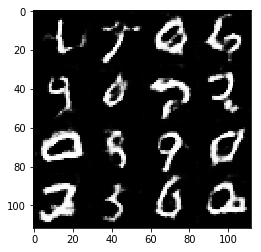

Epoch 2/2... Discriminator Loss: 0.8040... Generator Loss: 1.9877
Epoch 2/2... Discriminator Loss: 0.7587... Generator Loss: 1.4754
Epoch 2/2... Discriminator Loss: 0.7702... Generator Loss: 1.3178
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 1.1517
Epoch 2/2... Discriminator Loss: 0.9679... Generator Loss: 2.7004
Epoch 2/2... Discriminator Loss: 0.6734... Generator Loss: 1.6421
Epoch 2/2... Discriminator Loss: 0.7610... Generator Loss: 2.0524


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 11.0473
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 12.5947
Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 4.2030
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 2.7278
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 2.3064
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 2.9654
Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 3.5327
Epoch 1/1... Discriminator Loss: 0.4790... Generator Loss: 5.4265
Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 3.6307
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 3.7059


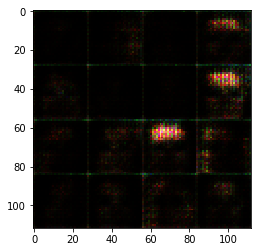

Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 4.7849
Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 5.3217
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 3.9405
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 5.8862
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 3.2091
Epoch 1/1... Discriminator Loss: 0.6619... Generator Loss: 2.2681
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 2.1120
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.5291


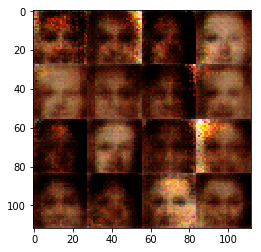

Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 1.9458
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 1.8635
Epoch 1/1... Discriminator Loss: 2.5811... Generator Loss: 0.1485
Epoch 1/1... Discriminator Loss: 1.9307... Generator Loss: 0.3649
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.4613
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 2.5102


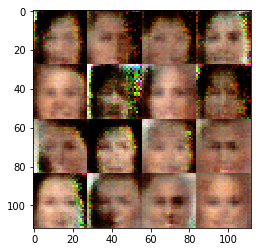

Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.8022
Epoch 1/1... Discriminator Loss: 1.9155... Generator Loss: 0.3237
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.4053
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.8609


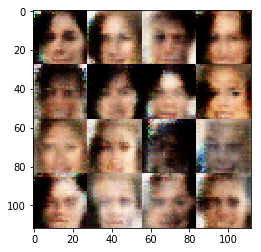

Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 1.5675
Epoch 1/1... Discriminator Loss: 1.8950... Generator Loss: 2.8326
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.6622
Epoch 1/1... Discriminator Loss: 1.9389... Generator Loss: 2.2763
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 1.8631... Generator Loss: 2.9198
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.5680


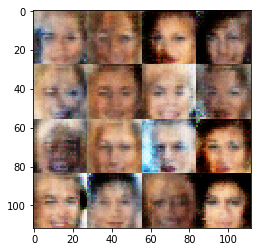

Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 2.2355
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 1.2352
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.4552
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 1.4628
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 0.3957


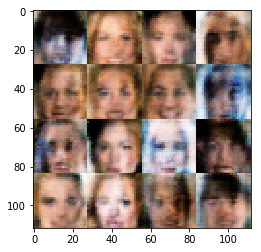

Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 1.7715
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 1.3491
Epoch 1/1... Discriminator Loss: 1.6617... Generator Loss: 2.2176
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.4243
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.8630


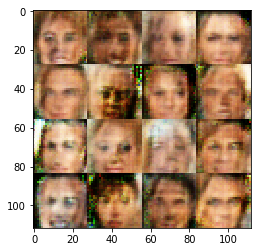

Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 1.6823
Epoch 1/1... Discriminator Loss: 2.2237... Generator Loss: 0.1946
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.9524


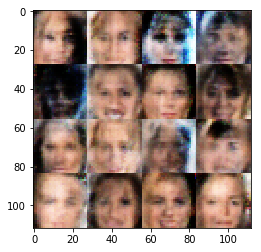

Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 2.1455... Generator Loss: 2.2471
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.2142
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.8312


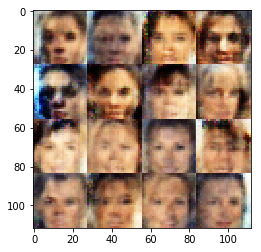

Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.5919... Generator Loss: 0.4575
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.8398


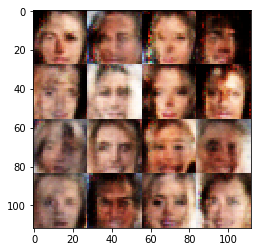

Epoch 1/1... Discriminator Loss: 1.7629... Generator Loss: 0.3331
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 1.1802
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8444


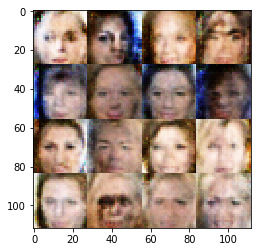

Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 1.3892
Epoch 1/1... Discriminator Loss: 1.8061... Generator Loss: 2.0404
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.6308... Generator Loss: 0.3995
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.7621


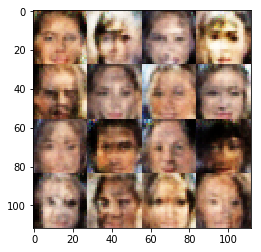

Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 1.3391
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 1.1848
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.8051


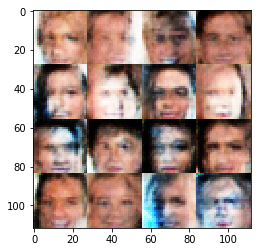

Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 1.0994
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.6795


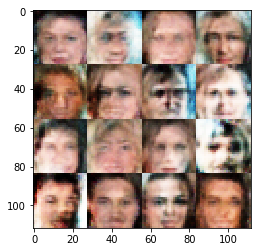

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7369


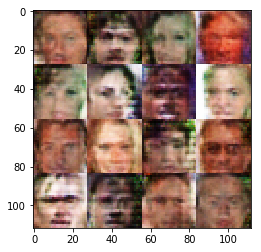

Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 1.0114


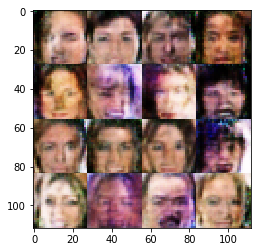

Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 1.5322
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.8474


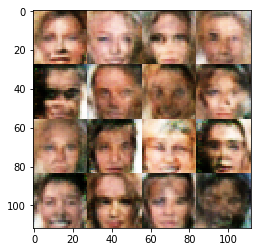

Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7622


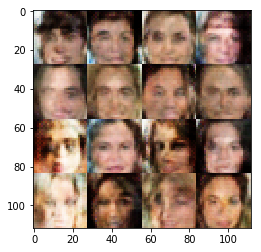

Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 1.5033
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 1.0028


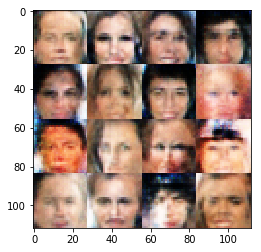

Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6072


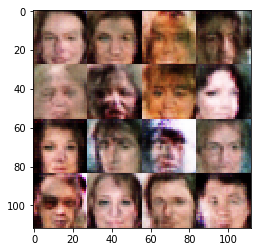

Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 1.5558
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 1.2696
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.9538


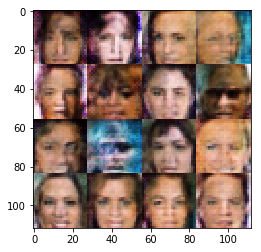

Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.5834


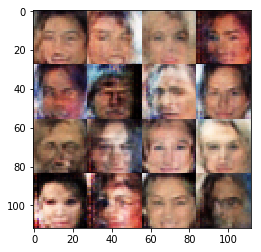

Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 1.3618
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7010


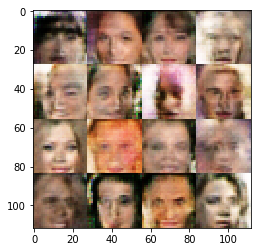

Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 1.0285


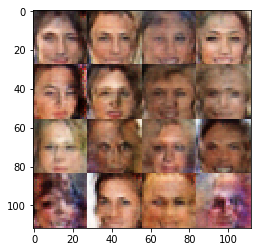

Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8598


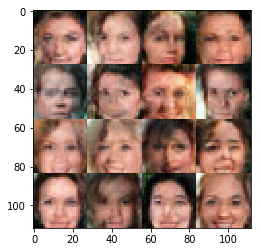

Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 1.1078
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.7910


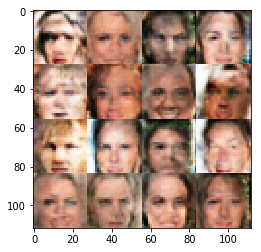

Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 1.2255
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7991


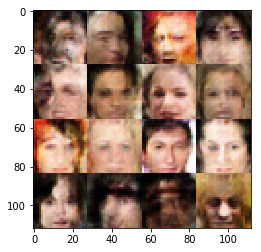

Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 1.3998
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.9376


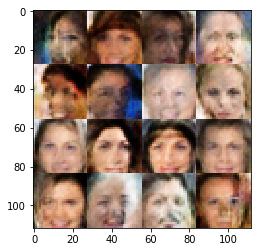

Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 1.0351


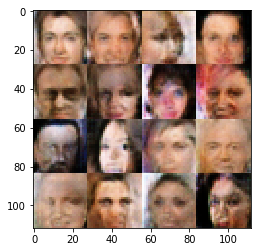

Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7598


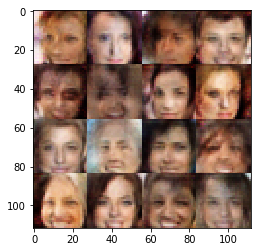

Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 1.1126
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.8811


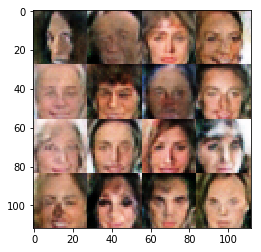

Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 1.1399
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 1.3833
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.8895


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.